#### ML for NLP
#### Final Project: Nomin Margad-Erdene

# Main Notebook: Data Preprocessing and Analysis

In [1]:
import pandas as pd
import numpy as np
import pickle
import string
from string import digits
import datetime
from datetime import datetime
import re
import nltk, nltk.stem as stem
from nltk.corpus import stopwords, words as nltk_words
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()
pd.options.mode.chained_assignment = None  # default='warn'
from pylab import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.25)
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from IPython.display import Image

# Introduction:
I am performing Sentiment Analysis and Classification using song lyrics and $\href{https://en.wikipedia.org/wiki/V_Live}{vlive}$ transcripts of the pop group BTS. 

BTS is often acclaimed for their positive messages and personal depth of lyrics. 

While VADER sentiment analysis tool is known to perform very well with social media texts, I want to check how well it can decipher the meanings and subtleties of poetry and lyrics. 

In addition, I use classification tools to check if song lyrics can be told apart from daily conversations. For this, I add the transcripts (subtitles) of livestreams of BTS from popular Korean live-streaming app V Live to the dataset.

An outline of the code process is described in the flowchart below.

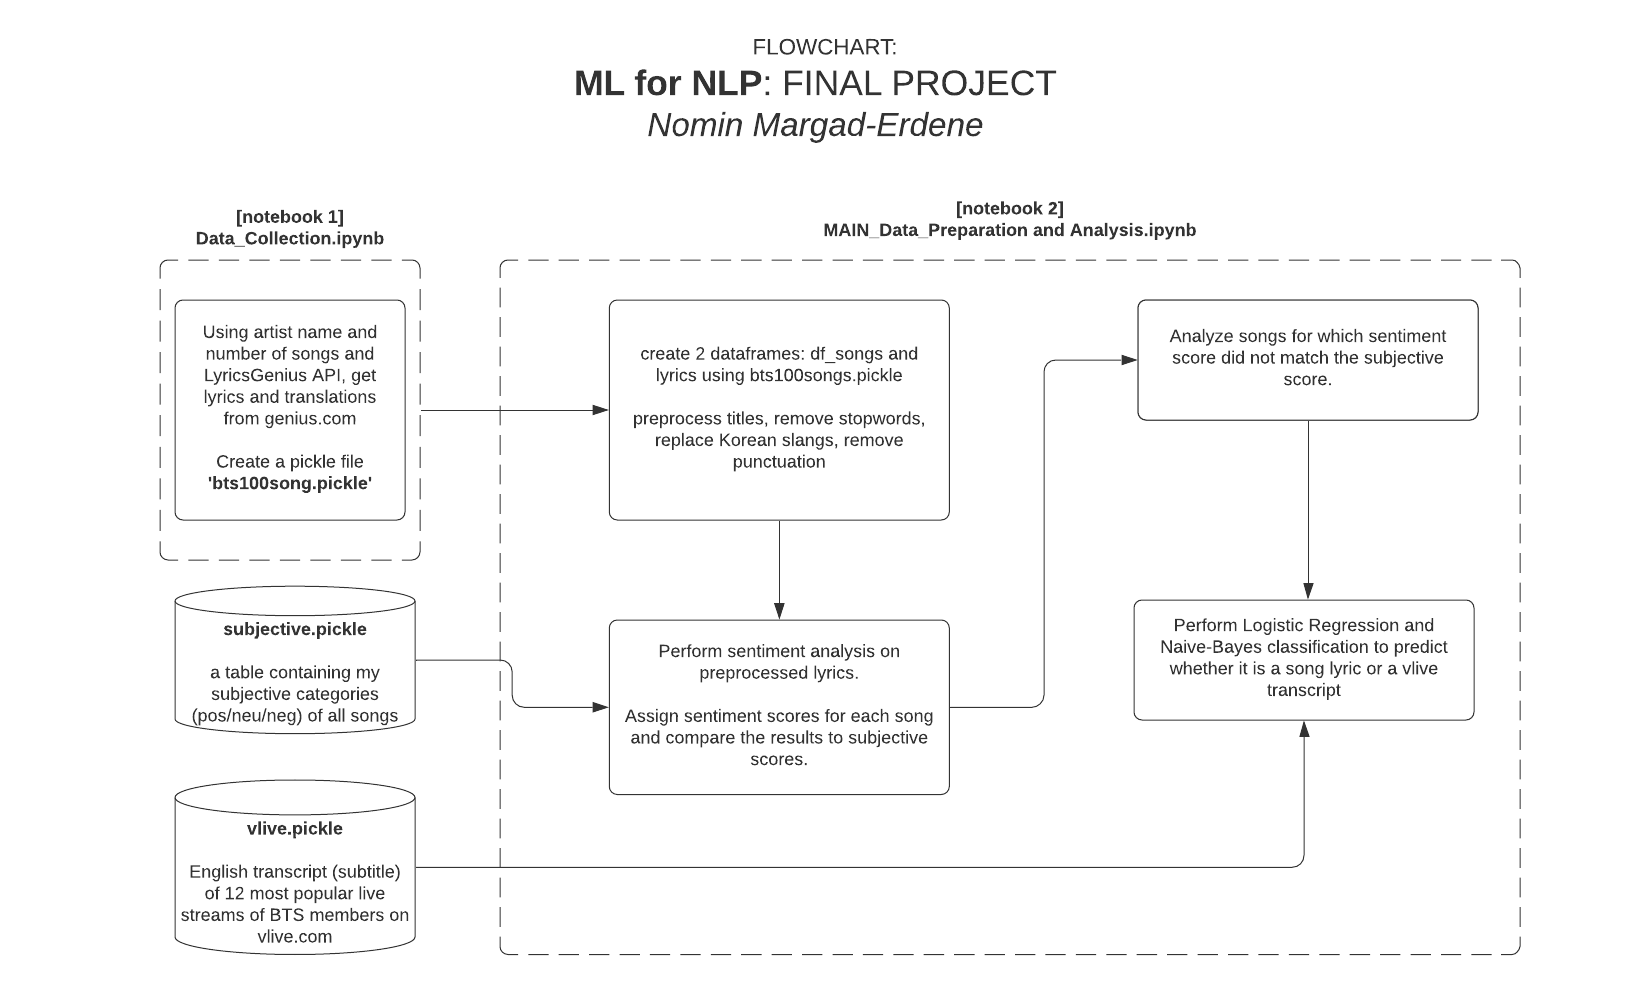

In [2]:
Image(filename = "flowchart.png", width=1000, height=900)

# Data:
I am working with 3 different sources of data. 

### 1 English Translations of 100 most popular BTS songs from Genius.com. 

I have prepared the translations as pickle file using LyricsGenius API. 

The script which scrapes the lyrics and saves them is in the notebook: Data_Collection. (The API takes some time to run and prints long text, so I separated the notebook)

From the file, I am able to extract 2 dataframes: 
* Dataframe [df_songs] has song titles as observations, and contains release date, lyrics as variables. 
* Dataframe [lyrics] contains each line of the lyric in a separate row. 

### 2 V Live transcrips

These are English subtitles of BTS's live-streams on Korean streaming app: "V Live". The text file contains total of 12 live streams each of which last 45 minutes on average. The members chat casually, discuss their recent concerts, new releases, hobbies and other events such as shoulder injury. 

Since BTS talks about casual topics on the live streams, I use this data for classifying casual text and song lyrics. 

I have used this $\href{https://home.soshistagram.com/naver_v/?lang=en}{website}$ to save English subtitles as text files. An example of a live stream can be found $\href{https://www.vlive.tv/post/1-18241401}{here}$.

### 3 Subjective sentiment scores

I have prepared an excel file which contains a categorical variable that takes values +1 (positive), 0 (neutral) or -1 (negative) for all songs included in the analysis based on my subjective opinion. I use it later to see how many songs have been mis-rated by Vader.

I think a proper way to create this file is to ask multiple people to rate the sentiment of the song. However, due to time constraints and size of the project, I just use my opinion.

In [3]:
#open the pickle file, which is an output of data_collection notebook:
with open('bts100songs.pickle', 'rb') as f:
    songs = pickle.load(f)

#create dataframe with songs in rows
df_songs = pd.DataFrame(
    {'Title': [s.title for s in songs],
     'Lyrics_Original': [s.lyrics for s in songs],
     'Album': [s.album for s in songs],
     'Year': [s.year for s in songs],
    } )

#Drop first row because it is not a song (note generated by API)
df_songs = df_songs.drop([0]).reset_index(drop = True)    

#Drop some songs that are remixes (therefore have same lyrics)
df_songs = df_songs[df_songs.Title.str.contains('[mM]ix') == False]

Dataframe that contains each song as observation (before preprocessing):

In [4]:
df_songs.head()

,Title,Lyrics_Original,Album,Year
0,BTS - FAKE LOVE (English Translation),"[Intro: V, Jungkook]\nFor you, I could pretend...",BTS - Love Yourself 轉 ‘Tear’ (English Translat...,2018-05-18
2,BTS - 전하지 못한 진심 (The Truth Untold) (English Tr...,[Verse 1: V]\nFull of loneliness\nThis garden ...,BTS - Love Yourself 轉 ‘Tear’ (English Translat...,2018-05-18
3,BTS - 봄날 (Spring Day) (English Translation),"[\nVerse 1: RM, J-Hope\n]\nMiss you\nSaying th...",BTS - You Never Walk Alone (English Translation),2017-02-13
4,BTS - DNA (English Translation),"[Verse 1: V]\nAt first sight, I could recogniz...",BTS- Love Yourself 承 ‘Her’ (English Translation)*,2017-09-18
5,BTS - Intro: Serendipity (세렌디피티) (English Tran...,"All this is no coincidence\nJust, just, by my ...",BTS- Love Yourself 承 ‘Her’ (English Translation)*,2017-09-04


In [5]:
print('We have ' + str(len(df_songs)) + ' songs out of 100 before preprocessing')

We have 85 songs out of 100 before preprocessing


Dataframe that contains English subtitles from live streams:

In [6]:
with open('btsvlives.pickle', 'rb') as f:
    vlive = pickle.load(f)
print("We have " + str(len(vlive)) + ' lines of text from live streams')
print('Sample V Live text:')
vlive.head(7)

We have 9187 lines of text from live streams
Sample V Live text:


,vlives
0,How do you know it's me
1,when you can't see me?
2,Nice to meet you everyone.
3,It's been a while.
4,Hi!
5,Long time no see.
6,"I'm right here, not gone to the bathroom."


Dataframe with subjective sentiment scores:

In [7]:
with open('subjective.pickle', 'rb') as f:
    subjective = pickle.load(f)
    
subjective.head()

,Subjective
Title,
FAKE LOVE,-1
The Truth Untold,-1
Spring Day,0
DNA,1
Intro: Serendipity,1


# Preprocessing of lyrics ([df_songs]):

## Preprocessing titles and album names

Titles and album names are not used in the analysis, but I remove the artist name, 'english translation' and Korean text so that it looks neat.

In [8]:
#Removing Korean text
def prep_titles2(text):
    return "".join(c for c in text if ord(c)<128)

#Removing extra strings
def prep_titles(text):
    text = re.sub('BTS\s-\s', '', text)
    text = re.sub('BTS-\s', '', text)
    text = re.sub('\s\(English\sTranslation\)', '', text)
    text = re.sub('\s\[English\sTranslation\]', '', text)
    text = re.sub('\(','',text)
    text = re.sub('\)','',text)
    text = re.sub('[*]','',text)    
    return text

In [9]:
for index,row in df_songs.iterrows():
    title = prep_titles2(row['Title'])
    title = prep_titles(title)
    row['Title'] = title.lstrip()
    
for index,row in df_songs.iterrows():
    if row['Album'] is None:
        row['Album'] = 'Single'
    else:
        title = prep_titles2(row['Album'])
        title = prep_titles(title)
        row['Album'] = title.lstrip()

Titles and album names are clean now:

In [10]:
df_songs.head()

,Title,Lyrics_Original,Album,Year
0,FAKE LOVE,"[Intro: V, Jungkook]\nFor you, I could pretend...",Love Yourself Tear,2018-05-18
2,The Truth Untold,[Verse 1: V]\nFull of loneliness\nThis garden ...,Love Yourself Tear,2018-05-18
3,Spring Day,"[\nVerse 1: RM, J-Hope\n]\nMiss you\nSaying th...",You Never Walk Alone,2017-02-13
4,DNA,"[Verse 1: V]\nAt first sight, I could recogniz...",Love Yourself Her,2017-09-18
5,Intro: Serendipity,"All this is no coincidence\nJust, just, by my ...",Love Yourself Her,2017-09-04


## Preprocessing Lyrics
First, I create a new dataframe of lyrics where each row in the lyric is a new row in the dataframe. The index of the dataframe is the title of the song.

In [11]:
lyrics = df_songs.set_index('Title').Lyrics_Original.str.split(r'\n').apply(pd.Series).stack().reset_index(level=1,drop=True).to_frame('Lyrics_Original')

Example: Searching for a song called "DNA"

In [12]:
lyrics.loc['DNA'].head()

,Lyrics_Original
Title,
DNA,[Verse 1: V]
DNA,"At first sight, I could recognize you"
DNA,As if we were calling for each other
DNA,The DNA in my blood vessels tell me
DNA,That it’s you I was looking all over for


### Stopwords:
I have decided to not use the built in stopwords because they do not provide improvement in performance (5 song sentiments were mis-identified due to including built in stopwords) and removing those words results in some lyrics losing their meaning.

Instead, I am using:
* Names of the members: lyrics contain sub-headers before each verse with the name of the member who sings the part. They needed to be removed, as they do not provide any information but are frequent. 
* Lyric-related stopwords: they indicate the part of the song (ex. hook, intro, outro) and are also irrelevant but frequent
* Some other stopwords: words like 'yeah', 'ay', 'oh' are used frequently. Some of them have positive sentiment in Vader. However, they are used as fillers in the song (without contributing to the meaning). 

For example: 'yeah' has positive sentiment score. But there is a lyric that goes: "Every noise, every sound becomes filled with pain yeah, yeah, yeah". The line seems to be a sad one, but due to use of too many yeah's the compound score is positive.

In [13]:
print(sentiment.polarity_scores("Every noise, every sound becomes filled with pain yeah, yeah, yeah"))

{'neg': 0.195, 'neu': 0.414, 'pos': 0.391, 'compound': 0.3182}


In [14]:
print(sentiment.polarity_scores("Every noise, every sound becomes filled with pain"))

{'neg': 0.32, 'neu': 0.68, 'pos': 0.0, 'compound': -0.5106}


In [15]:
stopwords_names = ['V','Jin','Jungkook','Kook','Taehyung', 'Rm', 'RM', 'SUGA', 'Namjoon', 'J-Hope', 'j-hope', 'Suga', 'Yoongi', 'Jimin', 'Jung', 'Rap' ,'Monster']
stopwords_other = ['bts','BTS', 'army', 'oh', 'Ah', 'Oh', 'whats', 'ay', 'oh', 'yeah','Yeah', 'La', 'lala', 'lalala', 'lalalala', 'lalalalala',
                 'hey', 'heh', 'na', 'ah', 'ye', 'ey', 'woah', 'woo', 'yeah', 'Oh-oh-owoah', 'Oh-oh-owoah-owoah', 'Dunkiduk', 'kungduruhruh', 
                   'brr', 'yo', 'yah', 'ya','Ilsan', 'Oh-oh-oh-oh-oh', 'oh-oh-oh-oh-oh', 'I-I-I-I-I-I-I-I']
stopwords_song = ['Verse', 'Hook', 'Intro', 'Outro', 'Chorus', 'Refrain', 'Pre-Hook', 'Pre-Chorus', 'Post-Chorus', 'Bridge', 'All']
stopwords_all = stopwords_names + stopwords_other + stopwords_song

def remove_stopwords(text):
    clean_stopwords=""
    for element in text.split():
        if element not in stopwords_all:
            clean_stopwords = clean_stopwords + " "+ element
    return clean_stopwords.strip()

### Changed words:
The English translations are overall accurate. However, because the original text is Korean, there are some idioms and words specific to Korean language that are not registered in Vader. I had to change them to meaningful synonyms. For example:

| Lyric | Replacement | Meaning |
| --- | --- | --- |
| kkeut | end | kkeut is a slang meaining something is finished |
| baepsae/crow-tit (translated as try-hard in lyrics) | loser | referring to people of middle/low class. there is a Korean idiom: "if crow-tit walks like a stork, it will break it's legs". The song uses idiom to address the pressure younger people without good background face for not working hard enough and being losers. Since try-hard has neutral sentiment in Vader, I changed it to loser which has negative sentiment to fit the meaning in the song|
| borahae/purple | love | a slang that means love. "I love/purple you" but the direct translation is purple.|
| army/ami | fan | name for bts fanbase (not related to soldiers). therefore replaced as fan|
| eolssu/usloo/ulssu | hooray | different versions meaning hooray/cheers used in Korean tradidional performances|

In [16]:
def alternative_words(text):
    old = ['kkeut', 'crowtit', 'try-hard' , 'skool', 'purple','Purple', 'army', 'Eolssu', 'Ulsoo', 'Ulssu', 'lovin', 'like a', ' em', 'Cuz', 'Anpanman']
    new = ['end', 'loser', 'loser', 'school', 'love', 'Love', 'fan', 'hooray', 'hooray', 'hooray', 'loving', 'a', ' them', 'Because', 'Hero']
    for o,n in zip(old,new):
        text = re.sub(o,n,text)
    return text

### Removing punctuations:

I am removing brackets, numbers and some other punctuations frequently found in the formatting of lyrics. 

The preprocessing ends here and I do not apply tokenization, bigrams, stemming and lemmatization because Vader works on complete sentences. The article $\href{https://towardsdatascience.com/an-short-introduction-to-vader-3f3860208d53}{here}$ also states that Vader needs minimum preprocessing. 

I attempted including lemmatization to see if it will help, but the final sentiment scores of each song do not change except for 1 song. However, including them may intervene with the flow of the original text or meaning of the song. Therefore, given a different sample of songs - I don't know if lemmatization and stemming will help or hinder the performance of Vader. For this reason, I am not using them. 

In [17]:
def prep_lyrics(text):
    text= re.sub('[,&;:\[\]\(\)’"]', '', text)           
    text= re.sub('/', ' ', text)
    text= re.sub('[0-9]', '', text)
    text = remove_stopwords(text)
    text = alternative_words(text)
    return text

In [18]:
lyrics['text'] = lyrics['Lyrics_Original'].apply(lambda x: prep_lyrics(x))
lyrics = lyrics[lyrics['text'].map(lambda d: len(d)) > 0]

### Sample of preprocessed lyrics:

In [19]:
lyrics.loc['IDOL'][19:25]

,Lyrics_Original,text
Title,,
IDOL,"Eolssu, I like it",hooray I like it
IDOL,You can’t stop me lovin’ myself,You cant stop me loving myself
IDOL,I like the shouts,I like the shouts
IDOL,You can’t stop me lovin’ myself,You cant stop me loving myself
IDOL,Ulssu,hooray
IDOL,Ulsoo,hooray


## Sentiment Analysis
I apply sentiment analysis to each line in the lyrics dataframe, and assign sentiment scores based on threshold 0.03. I have chosen a lower threshold than the commonly used one (0.05) because unlike text found on social media, in lyrics there are more instances when the sentiment is not recognized and left as neutral. 

Then I find mean score as average of all rows for each song. 

The mean scores are included in the songs dataframe and merged with the subjective scores. 

In [20]:
def sentiment_analysis(frame, colname):
    frame['compound'] = frame[colname].apply(lambda x: sentiment.polarity_scores(x)['compound'])
    frame['neutral'] = frame[colname].apply(lambda x: sentiment.polarity_scores(str(x))['neu'])
    frame['negative'] = frame[colname].apply(lambda x: sentiment.polarity_scores(str(x))['neg'])
    frame['positive'] = frame[colname].apply(lambda x: sentiment.polarity_scores(str(x))['pos'])
    frame['sentiment']=''
    #here I am applying it for column sentment in dataframe of each lyric (for each row of lyrics)
    frame.loc[frame.compound>0.03,'sentiment']=1
    frame.loc[(frame.compound>-0.03) & (frame.compound<0.05),'sentiment']=0
    frame.loc[frame.compound<-0.03,'sentiment']=-1
    return frame

In [21]:
#merging with the subjective scores on titles
songs = df_songs.merge(subjective, how='inner', on='Title')

In [22]:
songs['Score'] = np.nan

for i in range(len(songs['Title'])):
    #iterating through the lyrics dataframe using Titles obtained from songs dataframe
    song_test = lyrics.filter(like = songs['Title'][i], axis=0)
    #do the sentiment analysis for each song separately (gives scores for each row of lyrics)
    sentiment_res = sentiment_analysis(song_test, 'text')
    #get the mean sentiment score for each song and append it to the song dataframe
    songs.at[i, 'Score'] = sentiment_res['compound'].mean()
    #here I am applying threshold score to dataframe of songs (mean score for each song)
    songs.loc[songs.Score>0.03,'Sentiment']=1
    songs.loc[(songs.Score>-0.03) & (songs.Score<0.03),'Sentiment']=0
    songs.loc[songs.Score<-0.03,'Sentiment']=-1

### Dataframe of songs with subjective and Vader sentiment scores:

Subjective: subjective sentiment score assigned by me

Score: Mean sentiment score of the song according to Vader (average of all row scores of lyrics dataframe for each song)

Sentiment: Sentiment of the song (negative, neutral, positive) based on threshold 0.03 and column "Score"

Note: we do not have preprocessed lyrics in this dataframe, because sentiment analisys was performed on [lyrics] dataframe, only mean scores for each song were copied here.  

In [23]:
songs.head()

,Title,Lyrics_Original,Album,Year,Subjective,Score,Sentiment
0,FAKE LOVE,"[Intro: V, Jungkook]\nFor you, I could pretend...",Love Yourself Tear,2018-05-18,-1,0.264288,1.0
1,The Truth Untold,[Verse 1: V]\nFull of loneliness\nThis garden ...,Love Yourself Tear,2018-05-18,-1,-0.042646,-1.0
2,Spring Day,"[\nVerse 1: RM, J-Hope\n]\nMiss you\nSaying th...",You Never Walk Alone,2017-02-13,0,-0.027261,0.0
3,DNA,"[Verse 1: V]\nAt first sight, I could recogniz...",Love Yourself Her,2017-09-18,1,0.068529,1.0
4,Intro: Serendipity,"All this is no coincidence\nJust, just, by my ...",Love Yourself Her,2017-09-04,1,0.240563,1.0


In [24]:
#Example of sentiment analysis on lyrics of last song:
sentiment_res.iloc[2:4,:]

,Lyrics_Original,text,compound,neutral,negative,positive,sentiment
Title,,,,,,,
Epilogue: Young Forever,Did I make any mistakes today,Did I make any mistakes today,-0.3612,0.667,0.333,0.0,-1
Epilogue: Young Forever,How did the audience seem,How did the audience seem,0.0000,1.000,0.000,0.0,0


Next I check how many of the Vader sentiments match with subjective sentiments:

Vader is unable to agree (with me) on the sentiments of 16% out of 83 songs. I think it indicates that Vader underperforms on analysis of lyrics compared to analysis of texts conventional to it (such as social media). 

However, it is also worth noting that my subjective scores are possibly prone to bias. In the next section, I will return to mis-identified songs to analyze what causes discrepancy.

In [25]:
songs['Results'] = np.where(songs['Subjective']== songs['Sentiment'], True, False)
falses = songs[songs['Results'] == False]
print(str(round(100*len(falses)/len(songs))) + "% of the songs have been mis-identified compared to subjective perception of sentiment.")
songs.groupby('Results').count()

16% of the songs have been mis-identified compared to subjective perception of sentiment.


,Title,Lyrics_Original,Album,Year,Subjective,Score,Sentiment
Results,,,,,,,
False,13,13,13,13,13,13,13
True,70,70,70,70,70,70,70


## Plot: mean sentiment scores against time and album
Here I have plotted the mean sentiment score of each song against the release date. The colors indicate which album the song belongs to.

We can observe that, on average, BTS has more positive songs than negative songs. While we have songs from 18 albums which is almost the full BTS discography according to answer on $\href{https://www.quora.com/How-many-albums-does-BTS-have-in-total-Which-is-your-favorite-and-why}{Quora}$, our sample is the top 100 songs by popularity. As a result, there are not many songs from early periods (2014-2016) in our sample.

It does not necessarily cause problems to the analysis, because popular songs should have more weight in terms of what sentiment it carries to the public. It could also imply that the popular songs from BTS are the positive songs (or BTS gained popularity after releasing songs with more positive sentiment). However, as there is nothing to prove causal relationship, I can only say that BTS' popularity and positive sentiment in their songs have positive relationship.

However, if one is interested in understanding how the sentiments of the songs have changed throughout time and in having a more complete picture: all songs from each album should be included in the analysis. This entails further problems such as availability of translation (for earlier and not popular songs).

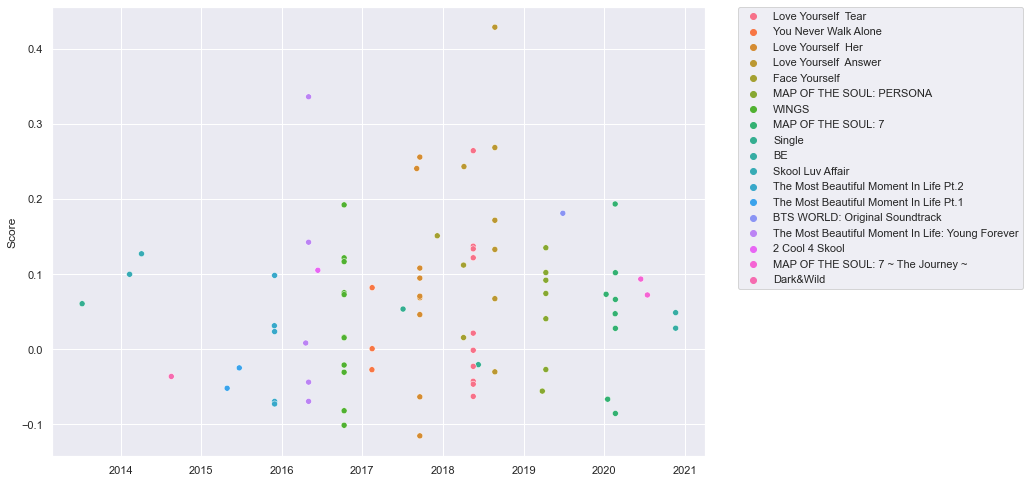

In [26]:
x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in songs['Year']]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x = x_values, y = songs['Score'], hue = songs['Album'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Here I display top and bottom 4 albums by mean and sum of sentiment scores:

The series of albums released between 2017 and 2019: Love Yourself: Her/Tear/Answer + WINGS (2016) is where the average sentiment score is higest (positive). This coincides with the time period when BTS' popularity gained momentum. These are also series of albums where songs were heavily focused on accepting, finding and loving oneself. 

On the other hand, earlier albums "Dark&Wild", "Most Beautiful Moment in Life 1/2" have lower and even negative scores. This is a period of time when the group members were younger and songs were focused on teenage emotions and frustrations.

In [27]:
t = pd.DataFrame({'Year': songs.groupby('Album').max()['Year'], 'Mean Scores': songs.groupby('Album').mean()['Score'], 'Sum of Scores': songs.groupby('Album').sum()['Score']}).sort_values(by = 'Sum of Scores', ascending = False)[0:4]
b = pd.DataFrame({'Year': songs.groupby('Album').max()['Year'], 'Mean Scores': songs.groupby('Album').mean()['Score'], 'Sum of Scores': songs.groupby('Album').sum()['Score']}).sort_values(by = 'Sum of Scores', ascending = False)[14:]

pd.concat([t, b], axis=0)

,Year,Mean Scores,Sum of Scores
Album,,,
Love Yourself Answer,2018-08-24,0.183136,1.281954
Love Yourself Her,2017-09-18,0.078383,0.705449
Love Yourself Tear,2018-05-18,0.056722,0.623946
WINGS,2016-10-10,0.034086,0.374941
You Never Walk Alone,2017-02-14,0.018463,0.055388
The Most Beautiful Moment In Life Pt.2,2015-11-30,0.002113,0.010567
Dark&Wild,2014-08-19,-0.036271,-0.036271
The Most Beautiful Moment In Life Pt.1,2015-06-23,-0.038399,-0.076798


### Here I only plot songs which match the subjective scores:
It looks like the cases where Vader score did not match subjective score is not conditional on albums or time.

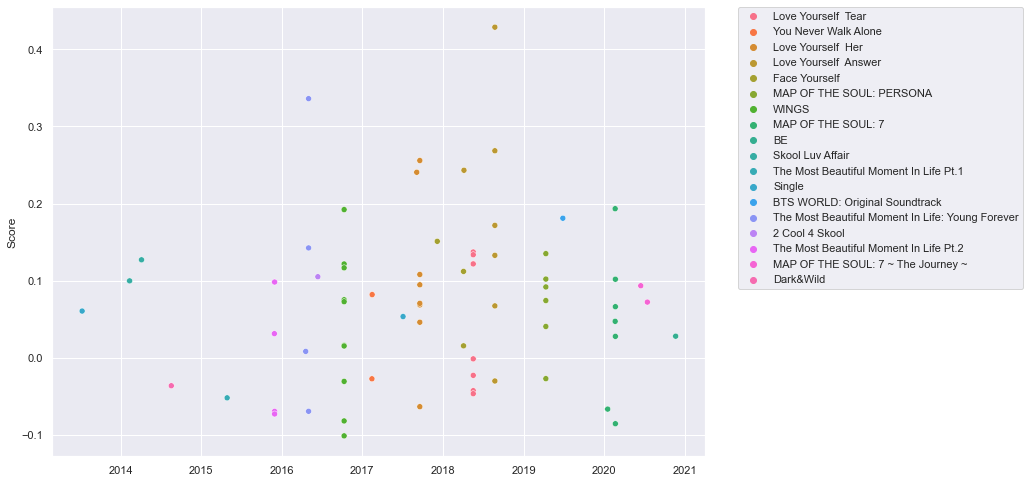

In [28]:
x1 = songs['Year'][songs['Results'] == True]
x2 = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in x1]
y1 = songs['Score'][songs['Results'] == True]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x = x2, y = y1, hue = songs['Album'][songs['Results'] == True])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Mis-identified songs:
Here, I am taking a look at which songs' sentiment scores from Vader did not match the subjective scores. 
(Under assumption that my subjective scores were correct, but the subjective scores should be revised by more than one person later.)

In [29]:
print('Titles of mis-identified songs:')
print(str(len(falses)) + 'songs')
falses[['Title','Results', 'Sentiment', 'Subjective']]

Titles of mis-identified songs:
13songs


,Title,Results,Sentiment,Subjective
0,FAKE LOVE,False,1.0,-1
16,Ddaeng,False,0.0,1
19,Outro: Tear,False,0.0,-1
20,Not Today,False,0.0,1
22,LIE,False,0.0,-1
28,Dimple,False,-1.0,1
31,So What,False,-1.0,0
32,Butterfly,False,0.0,1
36,DOPE,False,0.0,1
46,FIRE,False,-1.0,0


In [30]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### The factors that result in Vader and Sujective score mis-match are:

### Rap songs:
Among the total of 13 songs, 8 songs have heavy rap content compared to an average pop/BTS song. These songs are either fully rap or all verses except chorus are rap. Due to heavy lyricism in rap, which is exacerbated by the fact that the songs were originally Korean: Vader is almost unable to understand the sentiment of rap songs. 

A good example is a song "Ddaeng":

It repeats the Korean word Ddaeng almost in every line of the chorus, but in each line the word takes a different meaning. 

The first line "18, 13, 38 ddaeng" represents the winning combination in Korean traditional card game, and Ddaeng has a positive sentiment here.
However, in the second line "U wrong, me right look carfully ddaeng" the word is used in negative connotation representing the commonly used sound/phrase on TV shows when someone gives wrong answer: Ddaeng!

As a result, unless the preceding text alludes to the sentiment, Vader is unable to catch it.

(The reason I included "Ulsoo" into the list of words which I have replaced, and did not include "Ddaeng" is because this word has multiple positive and negative meanings. Replacing it with one of them will result in misleading results.)

More about this song can be found $\href{https://medium.com/ty-but-disagree/analyzing-rms-verse-on-ddaeng-1daa082bbe7d}{here}$.

In [31]:
ddaeng = lyrics.filter(like = songs['Title'][16], axis=0)
ddaeng_sen = sentiment_analysis(ddaeng, 'text')
ddaeng_sen.head()

,Lyrics_Original,text,compound,neutral,negative,positive,sentiment
Title,,,,,,,
Ddaeng,One-eight one-three three-eight ddaeng,One-eight one-three three-eight ddaeng,0.0000,1.000,0.000,0.000,0
Ddaeng,U wrong me right look carefully ddaeng,U wrong me right look carefully ddaeng,-0.3818,0.521,0.323,0.156,-1
Ddaeng,Ring the school bell brr brr ddaeng,Ring the school bell ddaeng,0.0000,1.000,0.000,0.000,0
Ddaeng,"This life is all wrong for you, ddaeng",This life is all wrong for you ddaeng,-0.4767,0.693,0.307,0.000,-1
Ddaeng,Hip-hop? ddaeng,Hip-hop? ddaeng,0.0000,1.000,0.000,0.000,0


Another example where a rap song clearly insults somebody by calling them "tasteless ratatouille", but Vader is unable to recognize negative sentiment.

In [32]:
micdrop = lyrics.filter(like = songs['Title'][9], axis=0)
micdrop_sen = sentiment_analysis(micdrop, 'text')
micdrop_sen.iloc[17:18,:]

,Lyrics_Original,text,compound,neutral,negative,positive,sentiment
Title,,,,,,,
MIC Drop,"I do it, I do it, you’re a tasteless ratatouille",I do it I do it youre a tasteless ratatouille,0.0,1.0,0.0,0.0,0


### Use of similies or figure of speech:

Another set of incorrectly classified songs are songs which rely heavily on figure of speech. 

For example: the song uses "Blue and Grey" to represent sadness, but Vader is unable to catch it, and gives positive score.

While it is possible to incorporate "Blue and Grey" into the list of words which I have changed, and replace it by "Sadness", this only implies that author needs to go through the text first to sort out every literary expression to aid Vader. This is not efficient and results will not be applicable out of sample.

In [33]:
bluegrey = lyrics.filter(like = songs['Title'][51], axis=0)
bg_sen = sentiment_analysis(bluegrey, 'text')
bg_sen.iloc[4:8,:]

,Lyrics_Original,text,compound,neutral,negative,positive,sentiment
Title,,,,,,,
BTS - Blue & Grey,I guess everyone's happy,I guess everyone's happy,0.5719,0.448,0.000,0.552,1
BTS - Blue & Grey,Can you look at me? 'Cause I am blue and grey,Can you look at me? 'Cause I am blue and grey,0.0516,0.893,0.000,0.107,1
BTS - Blue & Grey,The meaning of the tears reflected in the mirror,The meaning of the tears reflected in the mirror,-0.2263,0.808,0.192,0.000,-1
BTS - Blue & Grey,"My color hidden with a smile, blue and grey",My color hidden with a smile blue and grey,0.4019,0.654,0.000,0.346,1


Another example: Vader does not understand what it means to call someone $\href{https://en.wikipedia.org/wiki/Kafka_on_the_Shore}{\text{"My Kafka on the shore"}}$ (neither do I). 

In [34]:
butterfly = lyrics.filter(like = songs['Title'][32], axis=0)
bf_sen = sentiment_analysis(butterfly, 'text')
bf_sen.iloc[45:47,:]

,Lyrics_Original,text,compound,neutral,negative,positive,sentiment
Title,,,,,,,
Butterfly,My,My,0.0,1.0,0.0,0.0,0
Butterfly,Kafka on the shore,Kafka on the shore,0.0,1.0,0.0,0.0,0


### Conclusions:

* Vader is very convenient, as it does not require much preprocessing of text - and it makes Vader a good tool for analyzing meaningful text like lyrics.
* The amount of positive sentiments in BTS songs increases around the time the group has started gaining global popularity. However, I can't say anything about causality. Full sample of their songs and better subjective scores can be incorporated to improve the analysis
* Vader fails to understand heavy literary figures of speech and rap lyrics. Most likely, the fact that original lyrics were in Korean exacerbates the situation

Given the performance of Vader, I was curious if classification tools can tell lyrics and daily conversations apart. As I have a pretty good quality text file of BTS members speaking about daily activities (live stream transcripts in English), I am also implementing classification.

# Classification
I will be comparing Logistic Regression and Naive Bayes for classification. Unlike Vader, the tools may benefit from tokenization, lemmatization and stopwords. Therefore I analyze 4 cases below: 

I add labels to the data and concatenate the vlives and lyrics.

In [35]:
vlive['text'] = vlive['vlives'].apply(lambda x: prep_lyrics(x))
vlive_res = sentiment_analysis(vlive, 'text')
lyrics['labels'] = 'lyric'
vlive['labels'] = 'vlive'
vlive_nb = vlive[['text', 'labels']]
lyrics_nb = lyrics[['text', 'labels']]
vlive_nb.head()

,text,labels
0,How do you know it's me,vlive
1,when you can't see me?,vlive
2,Nice to meet you everyone.,vlive
3,It's been a while.,vlive
4,Hi!,vlive


In [36]:
nbsample = pd.concat([lyrics_nb, vlive_nb])
nbsample.head()

,text,labels
FAKE LOVE,For you I could pretend like I was happy when ...,lyric
FAKE LOVE,For you I could pretend like I was strong when...,lyric
FAKE LOVE,I wish love was perfect as love itself,lyric
FAKE LOVE,I wish all my weaknesses could be hidden,lyric
FAKE LOVE,I grew a flower that cant be bloomed in a drea...,lyric


In [37]:
nbsample.groupby('labels').describe()

text                      
       count unique       top freq
labels                            
lyric   5853   4016  Hey mama   22
vlive   9187   8578  - Right.   47

### Functions for additional preprocessing:
Both texts are already preprocessed up to the point where they are usable in Vader. Therefore, I remove built-in stopwords, lower the text, tokenize and lemmatize them.

In [38]:
additional_strings = string.punctuation
stopwords_all = stopwords.words('english')# Show the vector of stop words

In [39]:
def remove_punct_tokenize(text):
    text = text.lower()   
    return text.split()

def lower_selecter(text):
    if isinstance(text, str) == True:
        return text.lower()
    else:
        return text

def preprocessing_text(text):
    words = word_tokenize(lower_selecter(text))
    tokens = [word for word in words if word not in string.punctuation]
    lemmatizer = WordNetLemmatizer()
    tokens_lematized = [lemmatizer.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(tokens_lematized)
    return preprocessed_text

In [40]:
nbsample['text'] = nbsample['text'].apply(remove_stopwords)
nbsample['text1'] = nbsample['text'].apply(preprocessing_text)

Column [text] has not been lemmatized, column [text1] is lemmatized. I perform the 2 classification methods on both texts and compare the results:

In [41]:
nbsample.head()

,text,labels,text1
FAKE LOVE,For I could pretend like I happy I sad,lyric,for i could pretend like i happy i sad
FAKE LOVE,For I could pretend like I strong I hurt,lyric,for i could pretend like i strong i hurt
FAKE LOVE,I wish love perfect love,lyric,i wish love perfect love
FAKE LOVE,I wish weaknesses could hidden,lyric,i wish weakness could hidden
FAKE LOVE,I grew flower cant bloomed dream cant come true,lyric,i grew flower cant bloomed dream cant come true


In [42]:
X1 = nbsample['text'] 
X2 = nbsample['text1'] 
y =nbsample['labels']

## Classification Results:
Classification Reports below show that the best performance is achieved when we use Naive Bayes classifier on a text without Lemmatization. 

#### NB (without lemmatization) results:

Overall accuracy of NB is 90%, which indicates that classifier works well.

Precision (lyrics =0.93) and recall (vlive =0.96) means the estimator rearely mis-labeled vlive into lyrics. Lines from vlives were correctly recalled. Casual text is rearely predicted as song lyrics.

However lower precision (vlive = 0.88) and recall (lyric = 0.79) means that lyrics were classified as vlives. Since recall of lyrics is 0.79, some lyrics were not predicted as songs, and were instead predicted as casual text and resulted in lower precision score of vlive.

### Logistic Regression (without Lemmatization):

In [43]:
pipe = Pipeline([('transformer', vectorizer), ('estimator', clf)])
pipe = pipe.fit(X1,y)
print('Score: ', pipe.score(X1, y))
print(classification_report(y, pipe.predict(X1)))

Score:  0.8902260638297872
              precision    recall  f1-score   support

       lyric       0.91      0.79      0.85      5853
       vlive       0.88      0.95      0.91      9187

    accuracy                           0.89     15040
   macro avg       0.90      0.87      0.88     15040
weighted avg       0.89      0.89      0.89     15040



### Logistic Regression (with Lemmatization):

In [44]:
pipe = Pipeline([('transformer', vectorizer), ('estimator', clf)])
pipe = pipe.fit(X2,y)
print('Score: ', pipe.score(X1, y))
print(classification_report(y, pipe.predict(X1)))

Score:  0.8767287234042553
              precision    recall  f1-score   support

       lyric       0.90      0.77      0.83      5853
       vlive       0.87      0.94      0.90      9187

    accuracy                           0.88     15040
   macro avg       0.88      0.86      0.87     15040
weighted avg       0.88      0.88      0.87     15040



### NB (without Lemmatization):

In [45]:
pipe = Pipeline([('transformer', vectorizer), ('estimator', NB)])
pipe = pipe.fit(X1,y)
print('Score: ', pipe.score(X1, y))
print(classification_report(y, pipe.predict(X1)))

Score:  0.8958776595744681
              precision    recall  f1-score   support

       lyric       0.93      0.79      0.86      5853
       vlive       0.88      0.96      0.92      9187

    accuracy                           0.90     15040
   macro avg       0.90      0.88      0.89     15040
weighted avg       0.90      0.90      0.89     15040



### NB (with Lemmatization):

In [46]:
pipe = Pipeline([('transformer', vectorizer), ('estimator', NB)])
pipe = pipe.fit(X2,y)
print('Score: ', pipe.score(X2, y))
print(classification_report(y, pipe.predict(X2)))

Score:  0.8922207446808511
              precision    recall  f1-score   support

       lyric       0.93      0.79      0.85      5853
       vlive       0.88      0.96      0.92      9187

    accuracy                           0.89     15040
   macro avg       0.90      0.87      0.88     15040
weighted avg       0.90      0.89      0.89     15040



## References:

Majority of the references related to the data and interpretations is linked within the markdown cells.

https://towardsdatascience.com/an-short-introduction-to-vader-3f3860208d53

https://laptrinhx.com/a-sentiment-analysis-of-bts-songs-2796448704/

https://ther3journal.com/issue-1/an-analysis-of-youtube-comments-on-bts-using-text-mining/

https://medium.com/@nguy3409/discovering-overarching-themes-of-kpop-boy-band-bts-using-machine-learning-246c69115ac8

https://towardsdatascience.com/the-data-science-of-k-pop-understanding-bts-through-data-and-a-i-part-1-50783b198ac2